# Mobility data prep (Matt)

In [1]:
# imports and setup
from   ast import literal_eval
from   collections import Counter, defaultdict
from   geopy import distance
from   itertools import pairwise
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from   sklearn.linear_model import LinearRegression
import seaborn as sns
import string
from   unidecode import unidecode

data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')

## Load derived data

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

conlit = pd.read_csv(
    os.path.join(derived_dir, 'CONLIT_CharData_AP_5.csv.gz'), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit = conlit.fillna('').drop(columns='X')

## CONLIT GPE distances

In [3]:
gpe_counts = Counter()
for i in conlit.gpe_places:
    gpe_counts.update(i)
gpe_counts.most_common(20)

[('New York', 6683),
 ('London', 4367),
 ('Paris', 3673),
 ('America', 3477),
 ('Washington', 2412),
 ('England', 2087),
 ('California', 2064),
 ('Chicago', 2000),
 ('Boston', 1624),
 ('France', 1560),
 ('Rome', 1304),
 ('San Francisco', 1247),
 ('Los Angeles', 1247),
 ('Texas', 1047),
 ('New York City', 1046),
 ('Europe', 952),
 ('Berlin', 938),
 ('Manhattan', 908),
 ('Philadelphia', 862),
 ('Virginia', 854)]

### Geonames

In [4]:
gn_col_names = [
    'geonameid',
    'name',
    'asciiname',
    'alternatenames',
    'lat',
    'lon',
    'feature_class',
    'feature_code',
    'country_code',
    'cc2',
    'admin1_code',
    'admin2_code',
    'admin3_code',
    'admin4_code',
    'population',
    'elevation',
    'dem',
    'timezone',
    'mod_date'
]
gn = pd.read_csv(
    os.path.join(data_dir, 'geonames', 'allCountries.zip'), 
    sep='\t',
    names=gn_col_names,
    index_col=0,
    low_memory=False
)

gn_gpes = Counter()
for i in conlit.gpe_places:
    gn_gpes.update(i)
gn = gn.loc[gn.name.isin(gn_gpes)]

# retain only most-populous place per unique name
gn = gn.sort_values(by='population', ascending=False).drop_duplicates(subset=['name']).set_index('name')

In [5]:
# not used in current implementation
hierarchy = pd.read_csv(
    os.path.join(data_dir, 'geonames', 'hierarchy.zip'), 
    sep='\t',
    names=['parent', 'child', 'type']
)

feature_codes = pd.read_csv(
    os.path.join(data_dir, 'geonames', 'featureCodes_en.txt'),
    sep='\t',
    names=['feature_code', 'feature_name', 'feature_description']
)

### Wilkens geo data

In [6]:
# regularize data to wilkens geo format
punctuation_to_space = str.maketrans({key:' ' for key in string.punctuation})

def regularize_string(place_string):
    return(unidecode(' '.join(place_string.translate(punctuation_to_space).lower().split())))

wi = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'geo.tsv.gz'),
    sep='\t',
    low_memory=False,
)
wi = wi.loc[wi.lang=='en']
wi.set_index('text_string', inplace=True)

# hand review data
hand = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'us_handreview.tsv'),
    sep='\t',
    index_col='text_string'
)

# restore some items from C19 hand review
hand.loc[
    [
        'hollywood', 
        'dallas', 
        'florence', 
        'kingston',
        'berkeley', 
        'queens', 
        'phoenix', 
        'woodstock', 
        'surrey',
        'orlando'
    ], 
    'ignore'
] = 0

# improve alises
hand.loc['kingston', 'alias_to'] = 'kingston jamaica'

# drop ignored places
wi = wi.drop(hand.loc[hand.ignore==1].index, errors='ignore')

# alias places
for original_place, alias_to in hand.loc[(~hand.alias_to.isna()) & (hand.ignore==0) & (hand.alias_to.isin(wi.index)), 'alias_to'].items():
    wi.loc[original_place] = wi.loc[alias_to]

# drop unused places
wi_gpes = Counter()
for sequence in conlit.gpe_sequences:
    wi_gpes.update([regularize_string(i) for i in sequence])
wi.drop(wi.loc[~wi.index.isin(wi_gpes)].index, inplace=True, errors='ignore')

### Sequence distances

For each volume sequence, look up each place, get lat/lon, calculate distance from previous place, sum over sequential path.

If `source='wilkens'`, also perform fancier location aliasing, ignore known-bad places, and zero out sequence steps that move between admin levels within the same admin entity (e.g., `Boston -> United States` or `UK -> England`). The last step has room for improvement: we don't deal with `admin_2` level and below (the distances involved are small), nor with continents (Google data doesn't place countries in continents, plus, I think there's a meaningful sense in which there's distance between, e.g., `Paris` and `Europe` in a way that there isn't between `Boston` and `USA`).

In [7]:
def get_lat_lon(place_string, geo_data, extended=False):
    '''Assumes lookup string has been regularized if necessary'''
    try:
        if extended:
            return(geo_data.loc[place_string, ['lat', 'lon', 'country_short', 'admin_1_std', 'location_type']])
        else:
            return(geo_data.loc[place_string, ['lat', 'lon']])
    except ValueError:
        return(None)

continents = { # not used in current implementation
    'africa',
    'antarctica',
    'asia',
    'australia',
    'europe',
    'north america',
    'south america'
}

def sequence_distance(sequence, source='geonames'):
    # set data, regularize strings, and remove unknown locations
    if source=='geonames':
        geo_data = gn
        seq = [i for i in sequence if i in geo_data.index]
    if source=='wilkens':
        geo_data = wi
        seq = [regularize_string(i) for i in sequence if regularize_string(i) in geo_data.index]
    total_distance = 0.0
    for location1, location2 in pairwise(seq):
        #print(location1, location2)
        if location1 in distances and location2 in distances[location1]:
            total_distance += distances[location1][location2]
        else:
            if source=='wilkens':
                loc1 = get_lat_lon(location1, geo_data, extended=True)
                loc2 = get_lat_lon(location2, geo_data, extended=True)
                if loc1 is None or loc2 is None: pass # should never happen, but check
                # eliminate place -> higher-order place in same admin area
                if (loc1.location_type=='country' or loc2.location_type=='country') and \
                   (loc2.country_short==loc1.country_short): pass
                elif (loc1.location_type=='administrative_area_level_1' or \
                      loc2.location_type=='administrative_area_level_1') and \
                     (loc2.country_short==loc1.country_short and \
                      loc2.admin_1_std==loc1.admin_1_std): pass
                else:
                    loc1 = loc1[['lat', 'lon']]
                    loc2 = loc2[['lat', 'lon']]   
                    dist = distance.distance(loc1, loc2).miles
                    total_distance += dist
                    distances[location1][location2] = dist
                    distances[location2][location1] = dist
            else:
                loc1 = get_lat_lon(location1, geo_data)
                loc2 = get_lat_lon(location2, geo_data)
                if loc1 is None or loc2 is None: pass # should never happen, but ...
                else: #compute dist and add to distances
                    dist = distance.distance(loc1, loc2).miles
                    total_distance += dist
                    distances[location1][location2] = dist
                    distances[location2][location1] = dist
    return(total_distance)

R^2 Sandeep/Wilkens naive v. Geoname naives: 0.893
CPU times: user 15.1 s, sys: 24.8 ms, total: 15.1 s
Wall time: 15.1 s


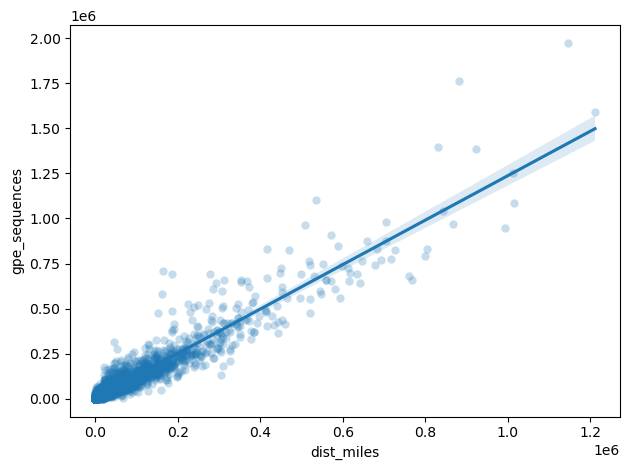

In [8]:
%%time
distances = defaultdict(lambda: defaultdict(float))
gn_distances = conlit['gpe_sequences'].apply(sequence_distance, source='geonames')

clf = LinearRegression().fit(X=conlit[['dist_miles']], y=gn_distances)
print(f"R^2 Sandeep/Wilkens naive v. Geoname naives: {clf.score(X=conlit[['dist_miles']], y=gn_distances):.3f}")

sns.regplot(x=conlit.dist_miles, y=gn_distances, scatter_kws={'alpha':0.25, 'linewidth':0})
plt.tight_layout()

In [9]:
%%time
distances = defaultdict(lambda: defaultdict(float))
wi_distances = conlit['gpe_sequences'].apply(sequence_distance, source='wilkens')

clf = LinearRegression().fit(X=conlit[['dist_miles']], y=wi_distances)
print(f"R^2 Wilkens naive v. Wilkens fancy: {clf.score(X=conlit[['dist_miles']], y=wi_distances):.3f}")

#sns.regplot(x=conlit.dist_miles, y=wi_distances, scatter_kws={'alpha':0.25, 'linewidth':0})
#plt.tight_layout()

R^2 Wilkens naive v. Wilkens fancy: 0.986
CPU times: user 25 s, sys: 29.5 ms, total: 25.1 s
Wall time: 25.1 s


In [10]:
X_wi = pd.DataFrame(wi_distances)
clf = LinearRegression().fit(X=X_wi, y=gn_distances)
print(f"R^2 Wilkens fancy v. Geonames naive: {clf.score(X=X_wi, y=gn_distances):.3f}")

R^2 Wilkens fancy v. Geonames naive: 0.865


### Save new distances to CSV

In [11]:
conlit['dist_miles'] = wi_distances
conlit.to_csv(os.path.join(derived_dir, 'CONLIT_CharData_AP_MW_5.csv.gz'))

In [12]:
conlit['dist_miles'].to_csv(os.path.join(derived_dir, 'CONLIT_CharData_dist_miles.csv.gz'))

## EARLY GPE distances

### Prepare early file

In [13]:
def read_hoplist(file_path, label='gpe'):
    df = pd.read_json(
        file_path,
        lines=True
    ).explode('chars')
    
    book_ids = []
    char_ids = []
    gpe_lists = []
    seq_lists = []
    for _, row in df.iterrows():
        book_id = row.book_id
        d = row.loc['chars']
        char_id = d['char_id']
        seq = d['sequence']
        seq_list = [place_dict['place'] for place_dict in seq]
        gpe_list = []
        for place_dict in seq:
            for i in range(place_dict['count']):
                gpe_list.append(place_dict['place'])
        seq_lists.append(seq_list)
        gpe_lists.append(gpe_list)
        book_ids.append(book_id)
        char_ids.append(char_id)

    result = pd.DataFrame(
        {
            'book_id':book_ids,
            'char_id':char_ids,
            f'{label}_places':gpe_lists,
            f'{label}_sequences':seq_lists
        }
    )
    return(result)

# read hoplists
early_gpes = read_hoplist(os.path.join(derived_dir, 'mb.hoplist.gpe.all.jsonl.bz2'), label='gpe')
early_nongpes = read_hoplist(os.path.join(derived_dir, 'mb.hoplist.non_gpe.all.jsonl.bz2'), label='nongpe')
early_allplaces = read_hoplist(os.path.join(derived_dir, 'mb.hoplist.all.all.jsonl.bz2'), label='all')

# read base data
base_early = pd.read_csv(
    os.path.join(derived_dir, 'inf_gender.1.tsv.gz'),
    sep='\t',
).drop(columns=['prob'])

# restrict to protagonists
early = base_early.merge(
    early_gpes, how='left', on=['book_id', 'char_id']
).merge(
    early_nongpes, how='left', on=['book_id', 'char_id']
).merge(
    early_allplaces, how='left', on=['book_id', 'char_id']
)

# reference format of original data for CONLIT
ref = pd.read_csv(
    os.path.join(derived_dir, 'book_char_mobility.tsv.bz2'),
    sep='\t'
)

# calculate simple derived columns
early['num_gpe_places'] = early['gpe_places'].apply(lambda x: len(set(x)))
early['num_nongpe_places'] = early['nongpe_places'].apply(lambda x: len(set(x)))
early['num_all_places'] = early['all_places'].apply(lambda x: len(set(x)))
early['char_rank'] = 1.0

# add token count
early_token_counts = pd.read_csv(
    os.path.join(derived_dir, 'mb.book_lengths.tsv'),
    sep='\t',
    skiprows=1,
    names=['book_id', 'Tokens']
)
early = early.merge(early_token_counts, how='left', on=['book_id'])

# add empty distance column and reorder columns to match reference
early['dist_miles'] = 0.0
proper_cols = [col for col in ref.columns.drop('num_words')]
proper_cols.append('Tokens')
early = early[proper_cols]

In [14]:
# glance at the data
early.sample(3)

,book_id,char_id,char_count,inf_gender,gpe_places,num_gpe_places,nongpe_places,num_nongpe_places,all_places,num_all_places,gpe_sequences,dist_miles,char_rank,Tokens
10323,00023517,0,5007,he/him/his,"[Rome, Genoa, Florence, Perugia, Florence, Gen...",15,"[the road, the building, here, that hotel in P...",210,"[Rome, the road, the building, Genoa, here, Fl...",224,"[Rome, Genoa, Florence, Perugia, Florence, Gen...",0.0,1.0,128635
6531,00024524,52,3690,he/him/his,"[Valdemaran, Valdemaran, Valdemar, Valdemar, G...",6,"[the woods, the cottage, the cottage, the cott...",82,"[the woods, the cottage, the cottage, the cott...",87,"[Valdemaran, Valdemar, Grove, Errold ’s Grove,...",0.0,1.0,134486
4501,00022954,0,2718,he/him/his,"[Maasailand, Maasailand, Earth, Earth, 882 G.E...",5,"[the Kikuyu, Wilford Braxton 's, Wilford Braxt...",93,"[the Kikuyu, Maasailand, Maasailand, Wilford B...",97,"[Maasailand, Earth, 882 G.E., Tahiti Benoit, K...",0.0,1.0,131175


### Calculate distances

In [15]:
# reread geo data to retain relevant locations, etc.
wi = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'geo.tsv.gz'),
    sep='\t',
    low_memory=False,
)
wi = wi.loc[wi.lang=='en']
wi.set_index('text_string', inplace=True)

# hand review data
hand = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'us_handreview.tsv'),
    sep='\t',
    index_col='text_string'
)

# restore some items from C19 hand review
hand.loc[
    [
        'hollywood', 
        'dallas', 
        'florence', 
        'kingston',
        'berkeley', 
        'queens', 
        'phoenix', 
        'woodstock', 
        'surrey',
        'orlando'
    ], 
    'ignore'
] = 0

# improve alises
hand.loc['kingston', 'alias_to'] = 'kingston jamaica'

# drop ignored places
wi = wi.drop(hand.loc[hand.ignore==1].index, errors='ignore')

# alias places
for original_place, alias_to in hand.loc[(~hand.alias_to.isna()) & (hand.ignore==0) & (hand.alias_to.isin(wi.index)), 'alias_to'].items():
    wi.loc[original_place] = wi.loc[alias_to]

In [16]:
# drop unused places
wi_gpes = Counter()
for sequence in early.gpe_sequences:
    wi_gpes.update([regularize_string(i) for i in sequence])
wi.drop(wi.loc[~wi.index.isin(wi_gpes)].index, inplace=True, errors='ignore')

In [17]:
%%time
# calculate distances
distances = defaultdict(lambda: defaultdict(float))
early_distances = early['gpe_sequences'].apply(sequence_distance, source='wilkens')

CPU times: user 40.9 s, sys: 47.4 ms, total: 40.9 s
Wall time: 40.9 s


### Save new distances to CSV

In [18]:
early['dist_miles'] = early_distances
early.set_index('book_id', inplace=True)
early.to_csv(os.path.join(derived_dir, 'EARLY_CharData_MW.csv.gz'))
early['dist_miles'].to_csv(os.path.join(derived_dir, 'EARLY_CharData_dist_miles.csv.gz'))

### Check EARLY distances

In [19]:
early.describe()

,char_id,char_count,num_gpe_places,num_nongpe_places,num_all_places,dist_miles,char_rank,Tokens
count,10693.000000,10693.000000,10693.000000,10693.000000,10693.000000,10693.000000,10693.0,1.069300e+04
mean,133.157019,2928.077153,11.285794,93.092677,104.060881,29417.895816,1.0,1.157649e+05
std,217.618373,2021.123267,10.486673,61.809811,69.181629,48108.827763,0.0,6.650997e+04
min,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,1.0,3.190000e+02
25%,0.000000,1560.000000,4.000000,49.000000,55.000000,2240.269955,1.0,7.692100e+04
50%,90.000000,2519.000000,9.000000,82.000000,91.000000,13369.838032,1.0,1.019410e+05
75%,190.000000,3780.000000,15.000000,123.000000,137.000000,36431.983953,1.0,1.390170e+05
max,9403.000000,22946.000000,146.000000,623.000000,726.000000,788452.017943,1.0,1.331338e+06


In [20]:
conlit.dist_miles.divide(conlit.Tokens).mean()

0.502130632355569

In [21]:
early.dist_miles.divide(early.Tokens).mean()

0.24894877927328699

In [22]:
early_gpe_counts = Counter()
for i in early.gpe_places:
    early_gpe_counts.update(i)
early_gpe_counts.most_common(20)

[('New York', 14926),
 ('London', 8615),
 ('Paris', 7636),
 ('America', 5850),
 ('England', 5622),
 ('Chicago', 4830),
 ('California', 4201),
 ('Boston', 4026),
 ('France', 3334),
 ('Washington', 3168),
 ('Rome', 3084),
 ('San Francisco', 2982),
 ('Virginia', 2133),
 ('Texas', 2102),
 ('Mexico', 2057),
 ('New Orleans', 1844),
 ('Los Angeles', 1812),
 ('Europe', 1645),
 ('Florida', 1563),
 ('Manhattan', 1348)]